# Plot the Data

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
from pathlib import Path

df_worker = pd.read_csv('drought_data_output/spei3_hf_raw.csv')
df_worker['date'] = pd.to_datetime(df_worker['date'])

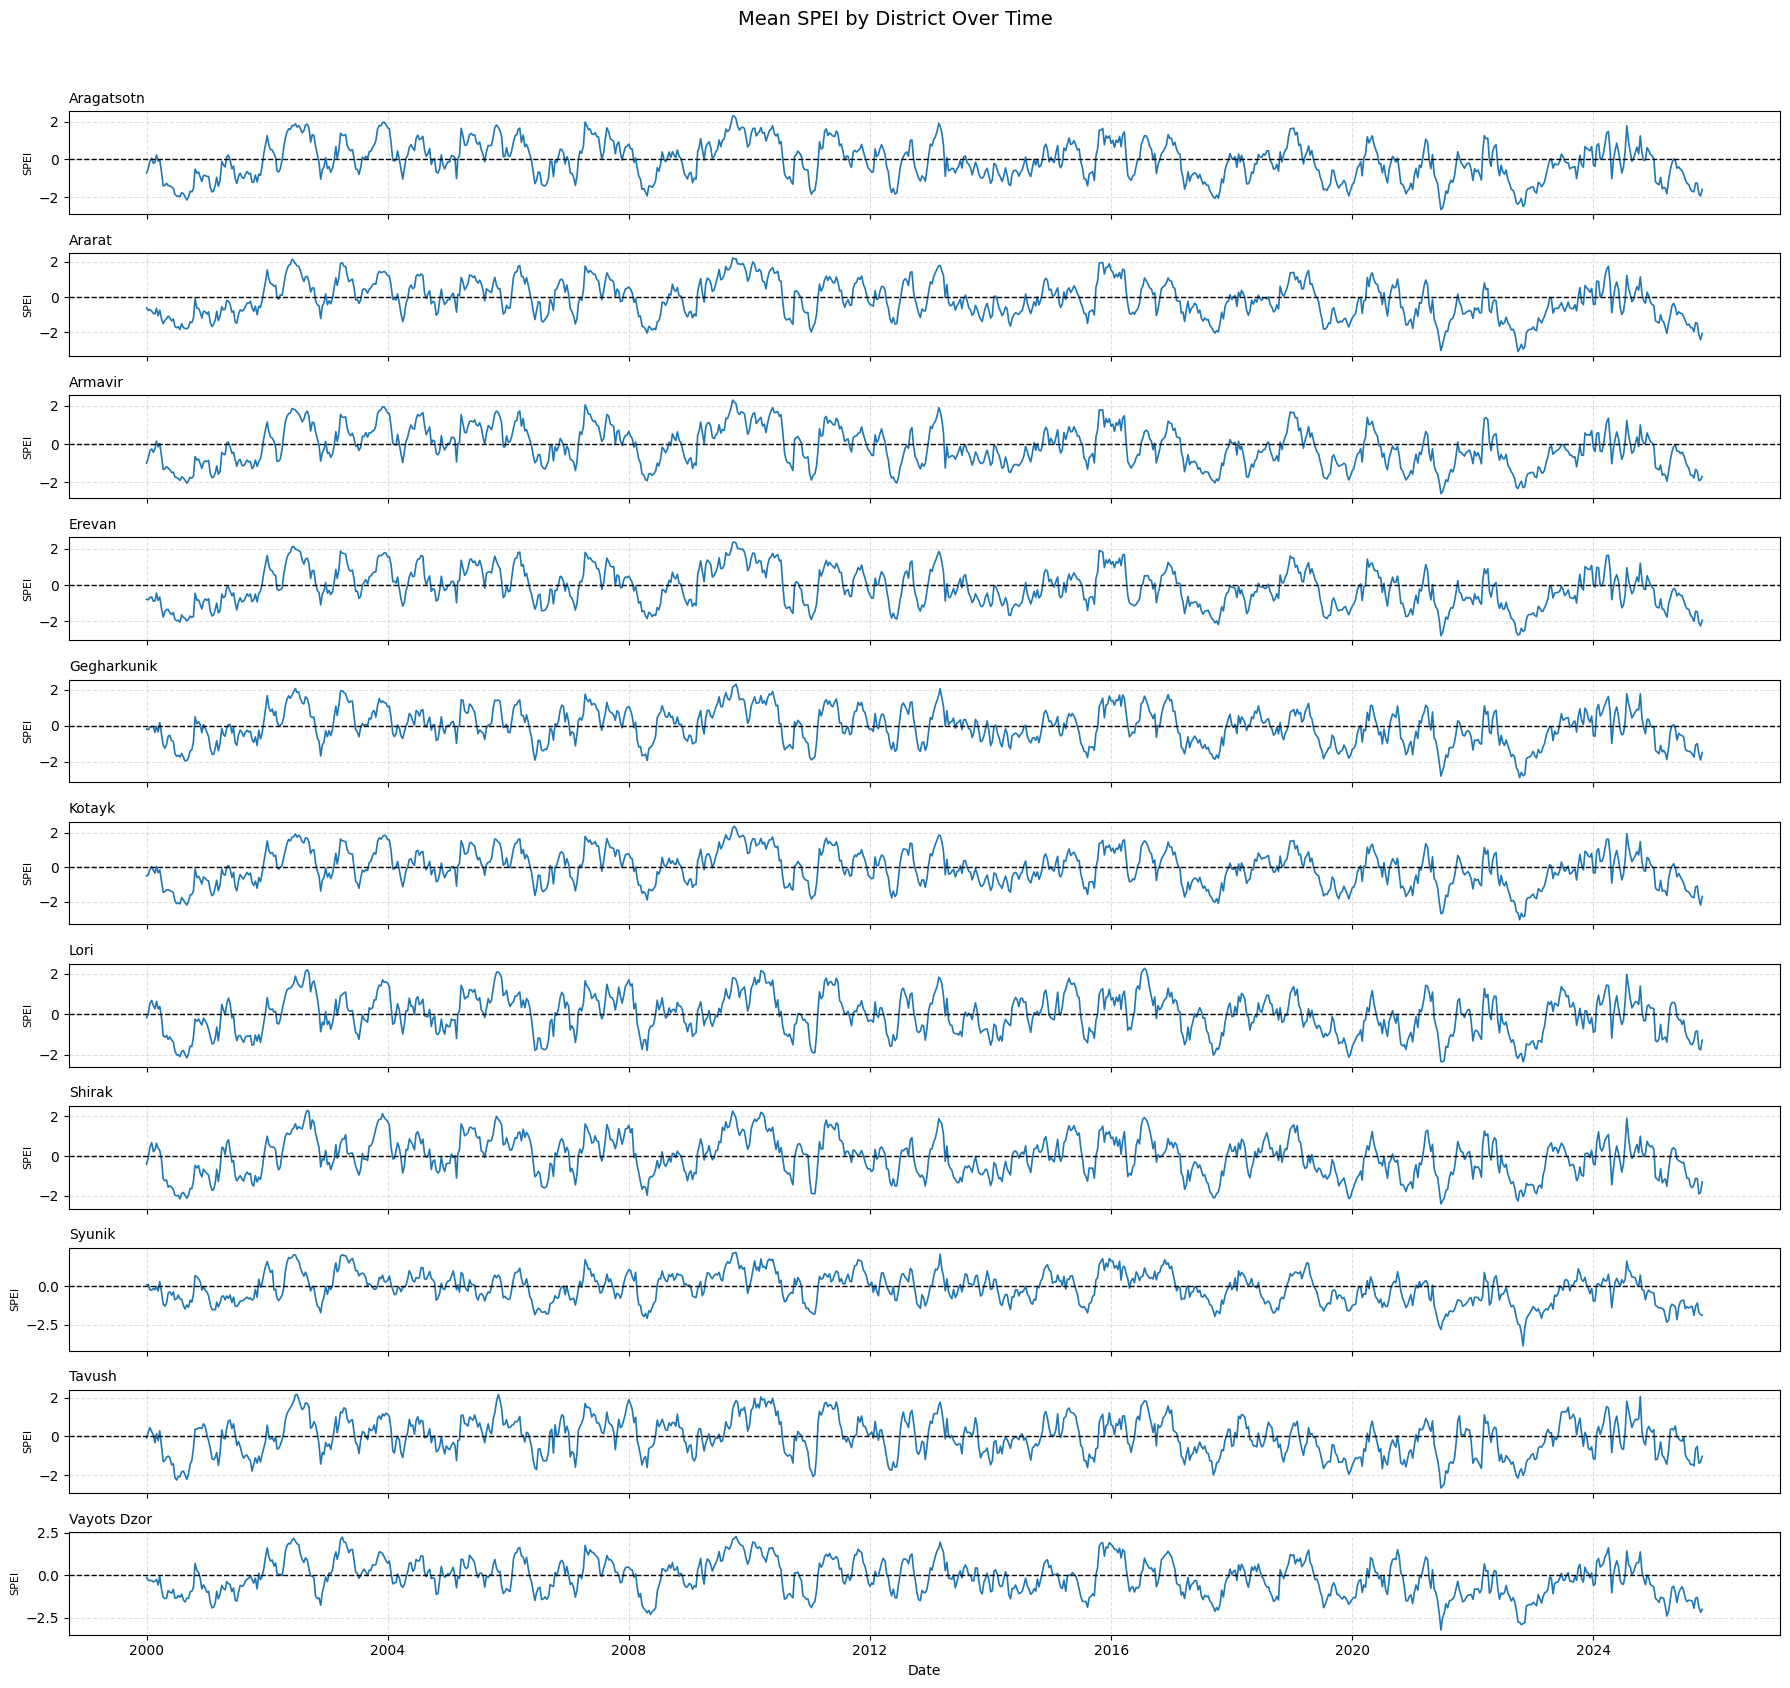

In [2]:

# --- Pivot data for easier plotting ---
df_ts = df_worker.pivot(index='date', columns='district', values='mean_spei')

# --- Create subplots ---
n_districts = len(df_ts.columns)
fig, axes = plt.subplots(n_districts, 1, figsize=(18, n_districts * 1.5), sharex=True)

# --- Plot each district ---
for ax, district in zip(axes, df_ts.columns):
    ax.plot(df_ts.index, df_ts[district], color='tab:blue', linewidth=1.2)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(district, fontsize=10, loc='left')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel("SPEI", fontsize=8)

# --- Shared X-axis and final formatting ---
plt.xlabel("Date")
plt.suptitle("Mean SPEI by District Over Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# Define Helper Functions

In [3]:
import pandas as pd
import numpy as np

# --- Define thresholds globally ---
thresh = -1    # threshold for consecutive drought
min_obs = 15
n_consecutive = 10  # minimum months per year for drought

# --- Function: max consecutive droughts ---
def max_consecutive_below(series, threshold=thresh):
    """
    Returns the maximum number of consecutive observations where series <= threshold.
    """
    is_drought = series <= threshold
    # Convert boolean to int and find max consecutive ones
    groups = (~is_drought).cumsum()
    consecutive_counts = is_drought.groupby(groups).sum()
    return int(consecutive_counts.max()) if not consecutive_counts.empty else 0

# --- Function: check consecutive droughts ---
def check_consecutive_drought(series, threshold=thresh, n_consecutive=n_consecutive):
    """
    Returns 1 if there are at least `n_consecutive` observations below threshold, else 0.
    """
    return int(max_consecutive_below(series, threshold) >= n_consecutive)

# --- Function: check total droughts per year ---
def check_total_droughts(series, threshold=thresh, n_required=min_obs):
    """
    Returns 1 if there are at least `n_required` observations <= threshold in the series, else 0.
    """
    return int((series <= threshold).sum() >= n_required)


# Prepare Full Data

In [7]:
df_worker = pd.read_csv('drought_data_output/spei3_hf_raw.csv')
df_worker['date'] = pd.to_datetime(df_worker['date'])
df_worker['year'] = df_worker['date'].dt.year

# Example: monthly SPEI series for a district
# Step 1: Mark drought months (1 if below threshold)
df_worker['drought_flag'] = (df_worker['mean_spei'] <= thresh).astype(int)
# Step 2: Group by year and apply checks
yearly = df_worker.groupby(['district', 'year'])['mean_spei'].agg([
    lambda x: check_consecutive_drought(x),  # 1 if >= n_consecutive
    lambda x: check_total_droughts(x), # 1 if >= min_obs
    lambda x: x.le(thresh).mean(),  # fraction of months that are drought
    lambda x: np.mean(x)  # fraction of months that are drought
])
yearly.columns = ['consec_drought', 'total_droughts', 'share', 'avg_spei3']
yearly = yearly.reset_index()
yearly

yearly['district'] = yearly['district'].replace({
    'Erevan': 'Yerevan',
    'Vayots Dzor': 'Vayots dzor',
    'Lori': 'Lor',
})

yearly.to_csv('drought_data_output/spei3_yearly_master.csv', index=False)


# Plot the Dummys


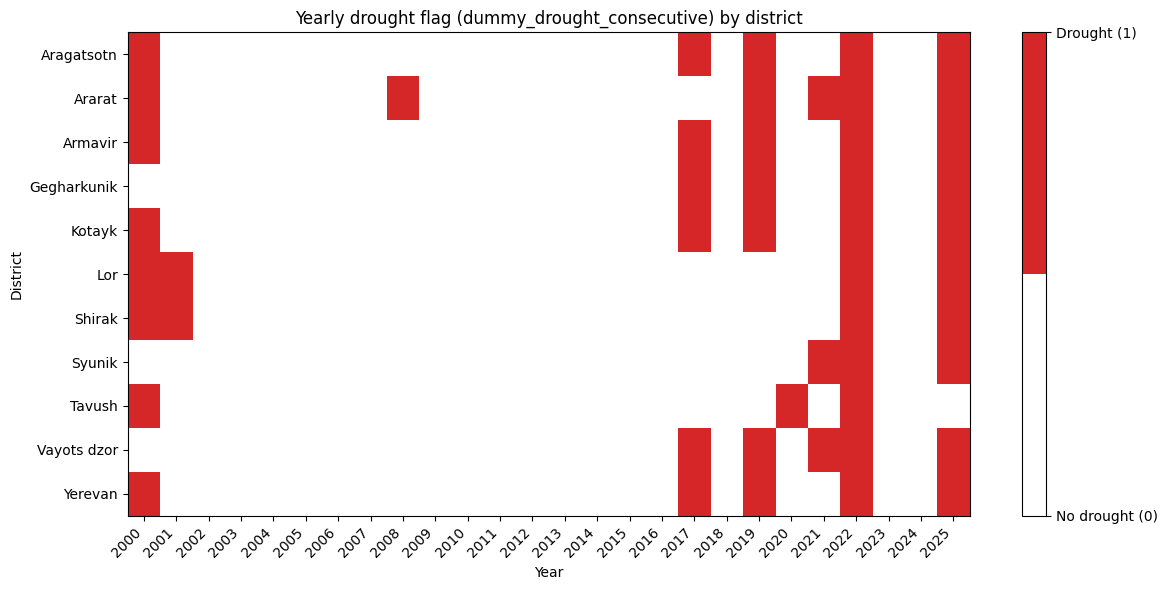

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Heatmap: yearly dummy_drought_consecutive for each district
# uses existing df_yearly_spei_2

# pivot to matrix (rows = district, cols = year)
pivot = yearly.pivot(index='district', columns='year', values='total_droughts')

# fill missing with 0 (no flag) and ensure integer type
pivot = pivot.fillna(0).astype(int)

years = pivot.columns.tolist()
districts = pivot.index.tolist()
data = pivot.values

fig, ax = plt.subplots(figsize=(12, 6))

# discrete colormap: 0 -> white (no drought), 1 -> red (drought)
cmap_flag = ListedColormap(['white', 'tab:red'])
im = ax.imshow(data, aspect='auto', cmap=cmap_flag, vmin=0, vmax=1)

# ticks and labels
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45, ha='right')
ax.set_yticks(range(len(districts)))
ax.set_yticklabels(districts)

ax.set_xlabel('Year')
ax.set_ylabel('District')
ax.set_title('Yearly drought flag (dummy_drought_consecutive) by district')

# colorbar with meaningful labels
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['No drought (0)', 'Drought (1)'])

plt.tight_layout()
plt.show()

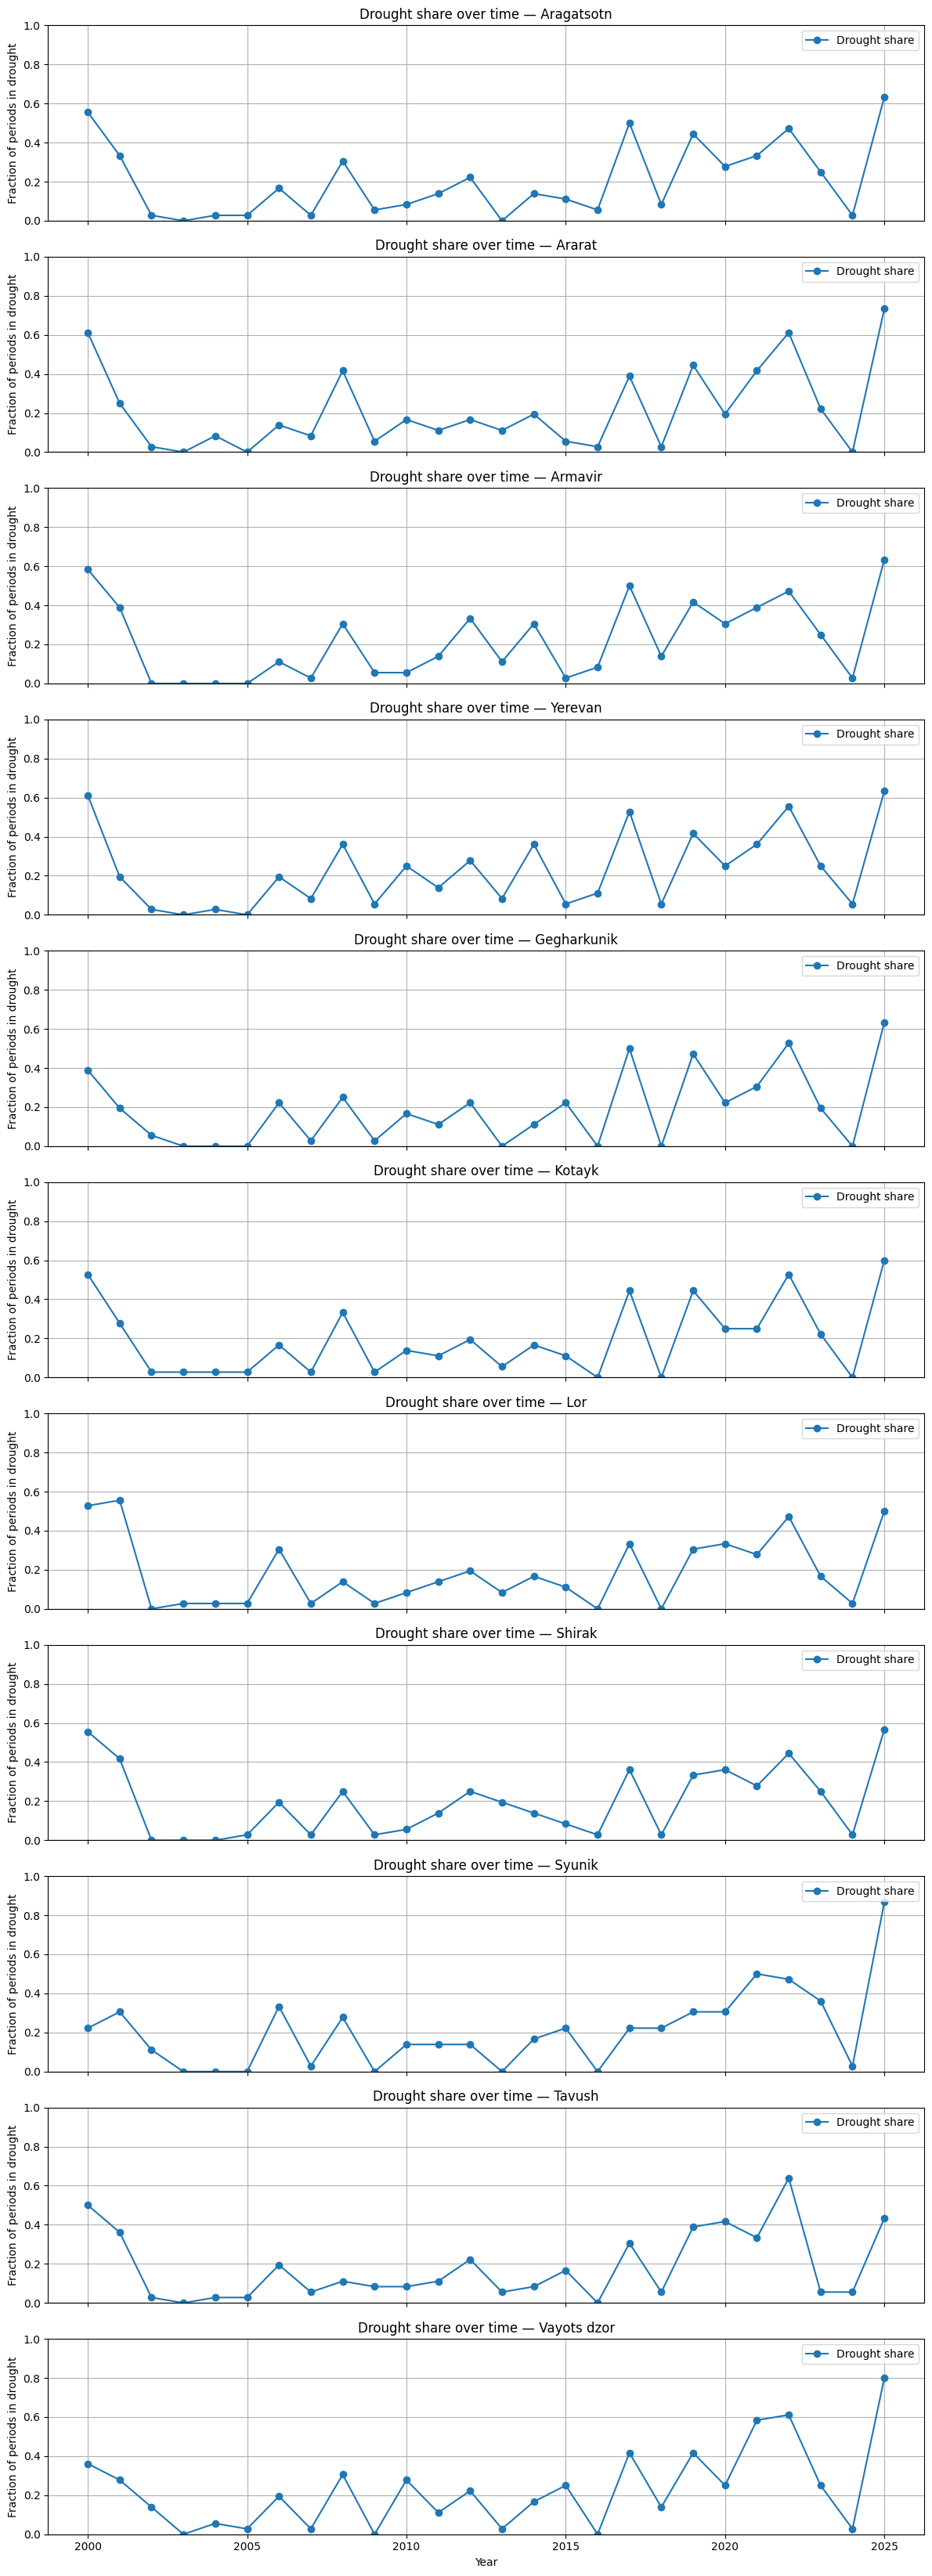

In [6]:
import matplotlib.pyplot as plt

# --- Plot share of droughts for each district ---
districts = yearly['district'].unique()
n_districts = len(districts)

fig, axes = plt.subplots(n_districts, 1, figsize=(12, 3*n_districts), sharex=True)

if n_districts == 1:
    axes = [axes]  # ensure axes is iterable

for ax, district in zip(axes, districts):
    data = yearly[yearly['district'] == district]
    ax.plot(data['year'], data['share'], marker='o', label='Drought share')
    ax.set_ylabel('Fraction of periods in drought')
    ax.set_title(f'Drought share over time — {district}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.legend()

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()
